### Gesture Classifier - Data Exploration

In [4]:
from data_handling import load_data, NUM_CLASSES, NUM_FEATURES, data_preprocessing
from ml_pipeline import get_classifiers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# streamlit.config
# Doppelte Ausfuehrung

# Enable autoreload of modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Print all model ids for retraining with /api/train
print(",".join(get_classifiers().keys()))

logistic_regression,random_forest_classifier,nearest_neighbors,support_vector_machine,naive_bayes,decision_tree,ada_boost,gradient_boosting,neural_network,linear_discriminant_analysis


In [5]:
X, y  = load_data(test_size=0)

Two time series only contain a single point and have been discarded from the dataset\
(info logs also reveal many txt-files that don't follow the naming convention)

In [20]:
df = pd.DataFrame(columns=["Time Series", "Label"])
df["Time Series"] = X
df["Label"] = y
df.head()

,Time Series,Label
0,"[[-0.07692308, -0.03846154, 0.44], [-0.0769230...",8
1,"[[-0.03846154, -0.2307692, 0.76], [-0.03846154...",1
2,"[[0.03846154, -0.4230769, 0.84], [0.03846154, ...",1
3,"[[0.1153846, -0.3846154, 0.84], [0.1153846, -0...",1
4,"[[0.07692308, -0.4230769, 0.88], [0.07692308, ...",1


In [16]:
df_stats = df.describe()
df_stats

,Time Series,Label
count,0,0
unique,0,0
top,NaN,NaN
freq,NaN,NaN


In [98]:
np.isclose(df_stats["Label"]["mean"], np.mean(range(1,NUM_CLASSES+1)), rtol=1e-4)

True

The mean of the classes being the mean of the labels is an indicator that the dataset is uniformly distributed

<Axes: xlabel='Label', ylabel='Count'>

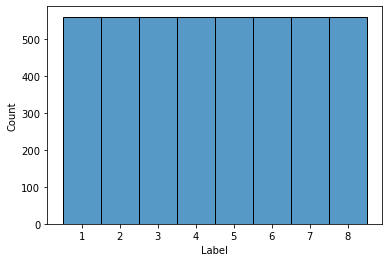

In [164]:
sns.histplot(data=df, x="Label", discrete=True)

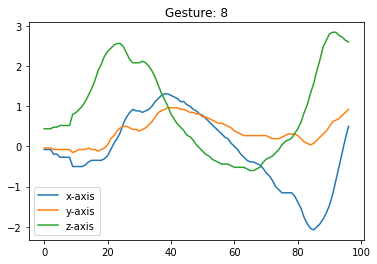

In [135]:
def plot_ts(time_series, label):
    sns.lineplot(data=time_series[:,0], label="x-axis")
    sns.lineplot(data=time_series[:,1], label="y-axis")
    sns.lineplot(data=time_series[:,2], label="z-axis")
    plt.title(f"Gesture: {label}")
    plt.show()

plot_ts(df["Time Series"][0], df['Label'][0])

The sine/cosine pattern in the signal of x/z confirms that it is a measurement of gesture 8 (counter-clockwise circle)

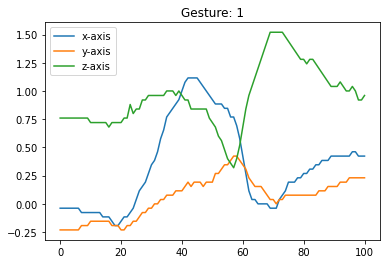

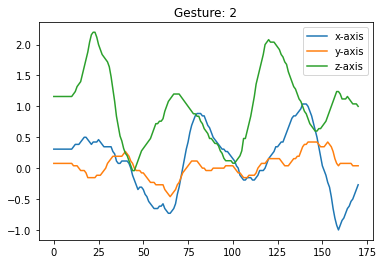

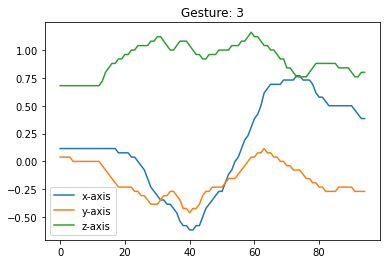

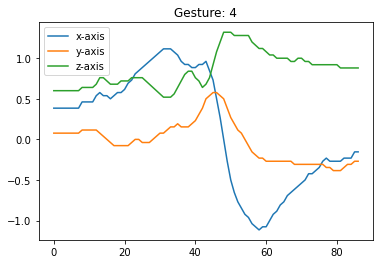

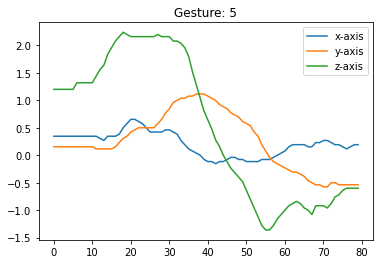

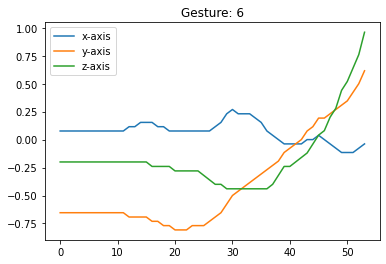

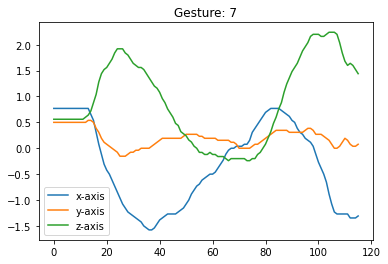

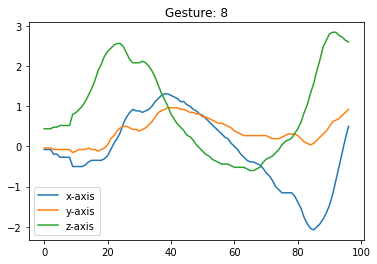

In [137]:
for i in range(1, NUM_CLASSES+1):
    i = df.loc[df['Label'] == i].index[0]
    plot_ts(df["Time Series"][i], df['Label'][i])

Similar observations can be made for all other gestures. The number of moments could be a promising feature.

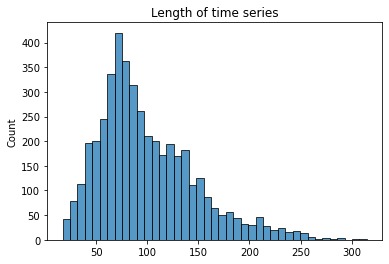

In [160]:
ts_lengths = [len(x) for x in df["Time Series"]]
sns.histplot(ts_lengths)
plt.title("Length of time series")
plt.show()

In [148]:
assert np.mean(ts_lengths) > np.median(ts_lengths)

We are dealing with time series of different length. The distribution is skewed to the right (mean_length > median_length).

Common strategies for resolving this issue include:
- Padding
- Trim
- Interpolate
- Discard

Trimming and discard are more useful when we are dealing with a few outliers. We will focus on padding and interpolation as we don't want to lose information.

For simplicity we will use zero-padding to max length for now. However, the other strategies might be worth exploring.
Another approach would be to use classifiers that process the sequence with a sliding window.

In [153]:
assert 3 * np.max(ts_lengths) == NUM_FEATURES

In [217]:
X_padded[0][:3] == X[0][0]

array([False, False, False])

In [218]:
X_padded = data_preprocessing(X, normalize=False)
assert len(X_padded[0]) == NUM_FEATURES
assert all(X_padded[0][:3] == X[0][0])

In [219]:
pd.DataFrame(X_padded, y).head()

,0,1,2,3,4,5,6,7,8,9,...,935,936,937,938,939,940,941,942,943,944
8,-0.076923,-0.038462,0.44,-0.076923,-0.038462,0.44,-0.076923,-0.038462,0.44,-0.192308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.038462,-0.230769,0.76,-0.038462,-0.230769,0.76,-0.038462,-0.230769,0.76,-0.038462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.038462,-0.423077,0.84,0.038462,-0.423077,0.84,0.038462,-0.423077,0.84,0.038462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.115385,-0.384615,0.84,0.115385,-0.384615,0.84,0.115385,-0.384615,0.84,0.115385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.076923,-0.423077,0.88,0.076923,-0.423077,0.88,0.076923,-0.423077,0.88,0.076923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
pd.DataFrame(np.concatenate(X_padded)).describe()

,0
count,4.231710e+06
mean,1.185616e-01
std,4.390776e-01
min,-4.230769e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,4.560000e+00


The data is not normalized

In [1]:
X_padded

NameError: name 'X_padded' is not defined

In [224]:
X_normalized = data_preprocessing(X, normalize=True)
stats = pd.DataFrame(np.concatenate(X_normalized)).describe()
stats

,0
count,4.231710e+06
mean,2.330579e-18
std,1.000000e+00
min,-8.693931e+00
25%,-3.294899e-01
50%,-2.360352e-01
75%,-8.760601e-02
max,1.110787e+01


In [229]:
assert np.isclose(stats.loc["mean"], 0) and np.isclose(stats.loc["std"], 1)

In [223]:
pd.DataFrame(X_normalized, y).head()

,0,1,2,3,4,5,6,7,8,9,...,935,936,937,938,939,940,941,942,943,944
8,-0.355905,-0.286527,0.576542,-0.355905,-0.286527,0.576542,-0.355905,-0.286527,0.576542,-0.564041,...,-0.217148,-0.217148,-0.217148,-0.217148,-0.217148,-0.217148,-0.217148,-0.217148,-0.217148,-0.217148
1,-0.536026,-1.103351,1.819508,-0.536026,-1.103351,1.819508,-0.536026,-1.103351,1.819508,-0.536026,...,-0.422561,-0.422561,-0.422561,-0.422561,-0.422561,-0.422561,-0.422561,-0.422561,-0.422561,-0.422561
1,-0.250457,-1.625504,2.137540,-0.250457,-1.625504,2.137540,-0.250457,-1.625504,2.137540,-0.250457,...,-0.365045,-0.365045,-0.365045,-0.365045,-0.365045,-0.365045,-0.365045,-0.365045,-0.365045,-0.365045
1,-0.007539,-1.464754,2.104300,-0.007539,-1.464754,2.104300,-0.007539,-1.464754,2.104300,-0.007539,...,-0.343820,-0.343820,-0.343820,-0.343820,-0.343820,-0.343820,-0.343820,-0.343820,-0.343820,-0.343820
1,-0.157792,-1.556965,2.089496,-0.157792,-1.556965,2.089496,-0.157792,-1.556965,2.089496,-0.157792,...,-0.373049,-0.373049,-0.373049,-0.373049,-0.373049,-0.373049,-0.373049,-0.373049,-0.373049,-0.373049
